<a href="https://colab.research.google.com/github/2025-02-FML-team/WV-Team/blob/main/notebooks/05_class_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = Path('/content/unpacked/')
    PACK_DIR = Path('/content/drive/My Drive/colab_drive/prepacked.zip')
    shutil.copy(PACK_DIR, '/content/')
    !unzip -o -q /content/prepacked.zip -d {DATA_DIR}
else:
    DATA_DIR= Path(os.path.join(os.getcwd(), "../data/")).resolve()
DATA_DIR

PosixPath('/Volumes/Backup/Workspace/ML/WV-Team/data')

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# CSV 로드 및 정리, 본인 경로에 맞게 변환
CSV_PATH = DATA_DIR / 'whiskies_relabel.csv'
IMAGE_SIZE = (224, 336)
RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

In [3]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize((IMAGE_SIZE[1], IMAGE_SIZE[0], ))
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/3042 [00:00<?, ?img/s]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 라벨 인코딩
labels = df["category"].values
le = LabelEncoder()
y_int = le.fit_transform(labels)

# test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y_int,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y_int
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

print("y_train 분포:", np.bincount(y_train))
print("y_test  분포:", np.bincount(y_test))

CLASS_NUM = len(le.classes_)
print("class mapping:", dict(zip(le.classes_, range(CLASS_NUM))))


X_train: (2585, 224, 336, 3)
X_test : (457, 224, 336, 3)
y_train 분포: [440 221 130 110 122 116 108 197 218 680 114 129]
y_test  분포: [ 78  39  23  20  21  21  19  35  38 120  20  23]
class mapping: {'Blended': 0, 'Bourbon': 1, 'Brandy': 2, 'Gin': 3, 'Liqueur': 4, 'Rum': 5, 'Rye': 6, 'SM_40_43': 7, 'SM_43_46': 8, 'SM_G46': 9, 'Tequila': 10, 'Vodka': 11}


In [5]:
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---- 증강할 대상 클래스 번호 ----
rye_class = 6
target_classes = [rye_class]

# ---- 증강 비율 (4배) ----
MULTIPLY = 4

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

aug_images = []
aug_labels = []

# 클래스별 개수 계산
counter = Counter(y_train)

for cls in target_classes:
    original_count = counter[cls]
    cls_indices = np.where(y_train == cls)[0]

    # 4배 → 추가해야 하는 개수 = (4 * original) - original
    n_needed = original_count * (MULTIPLY - 1)

    print(f"class {cls} original={original_count}, adding {n_needed} samples")

    for i in range(n_needed):
        idx = np.random.choice(cls_indices)
        img = X_train[idx]
        img = np.expand_dims(img, 0)

        for batch in datagen.flow(img, batch_size=1):
            aug_img = batch[0].astype(np.uint8)
            aug_images.append(aug_img)
            aug_labels.append(cls)
            break

# 기존 + 증강 데이터 합치기
if len(aug_images) > 0:
    X_train = np.concatenate([X_train, np.array(aug_images)], axis=0)
    y_train = np.concatenate([y_train, np.array(aug_labels)], axis=0)

class 6 original=108, adding 324 samples


In [6]:
print("After augmentation:", Counter(y_train))

After augmentation: Counter({9: 680, 0: 440, 6: 432, 1: 221, 8: 218, 7: 197, 2: 130, 11: 129, 4: 122, 5: 116, 10: 114, 3: 110})


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.array(range(CLASS_NUM)),
    y=y_train,
)

class_weight_dict = {}

i = 0;
for weight in class_weights_array:
    class_weight_dict[i] = weight
    i += 1

print(class_weight_dict)
# 예: {0: 0.8, 1: 1.2, 2: 3.4, ...}

{0: 0.5509469696969697, 1: 1.0969079939668176, 2: 1.8647435897435898, 3: 2.2037878787878786, 4: 1.9870218579234973, 5: 2.0897988505747125, 6: 0.5611496913580247, 7: 1.2305414551607445, 8: 1.1120030581039755, 9: 0.3564950980392157, 10: 2.1264619883040936, 11: 1.8791989664082687}


In [8]:
#03 노트북 코드++
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class ControllerCallback(Callback):
    def __init__(self, X_val, y_val, start_from_epoch=12, patient=3, tqdm=None):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = [] #this is for cumilating f1 per epoch
        self.start_from_epoch = start_from_epoch
        self.patient = patient
        self.out = 0
        self.best_f1 = -1
        self.epochs = 0
        self.tqdm = tqdm

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        if self.y_val.ndim == 2:
            y_true = np.argmax(self.y_val, axis=1)
        else:
            y_true = self.y_val

        f1 = f1_score(y_true, y_pred, average='macro')
        self.f1_scores.append(f1)
        logs['val_macro_f1'] = f1

        if f1 > self.best_f1:
            self.best_f1 = f1

        if 1 < epoch and epoch > self.start_from_epoch and f1 < self.f1_scores[-2]:
            if not tqdm:
                print(f"\nNon Improvement detected at EP : {epoch}, f1 : {f1}")
            self.out += 1

        if self.tqdm:
            self.tqdm.set_postfix(epochs=self.epochs, curr_f1=f1, best_f1=self.best_f1, strikes=self.out)

        if self.out >= self.patient:
            if not tqdm:
                print(f"\nStopping at EP : {epoch}, f1 : {f1}")
            self.model.stop_training = True

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.activations import gelu

#the name keyword is just there to use kwargs, it's not actually used.
def build_model(
    hidden=[200, 200],
    conv=[16, 32, 64],
    conv_double=True,
    input_dim=IMAGE_SIZE,
    name=""
):
    inputs = keras.Input(shape=(input_dim[0], input_dim[1], 3))

    x = inputs
    for cl in conv:
        x = layers.Conv2D(cl, (3,3), activation='relu', padding='same')(x)
        if conv_double:
            x = layers.Conv2D(cl, (3,3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)

    for hl in hidden:
        x = layers.Dense(hl)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('gelu')(x)

    outputs = layers.Dense(CLASS_NUM, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test set 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# 모델 생성
model = build_model(**{
    "name": "model_v_final",
    "input_dim": (224, 336),
    "hidden": [200, 200],
    "conv": [16, 32, 64], 
    "conv_double": True
})

# f1 + early stopping + progress
controller = ControllerCallback(
    X_test, y_test,
    start_from_epoch=15,
    patient=100
)

ckpt = ModelCheckpoint(
    filepath= DATA_DIR / "model_v_final_checkpoint.keras",
    monitor="val_macro_f1",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    callbacks=[controller, ckpt],
    class_weight=class_weight_dict,
    verbose=1,
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2596 - loss: 2.1657
Epoch 1: val_macro_f1 improved from None to 0.06602, saving model to /workspace/WV-Team/data/model_v_final_checkpoint.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.3290 - loss: 1.9879 - val_macro_f1: 0.0660
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5753 - loss: 1.1514
Epoch 2: val_macro_f1 did not improve from 0.06602
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6026 - loss: 1.1069 - val_macro_f1: 0.0322
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7814 - loss: 0.6483
Epoch 3: val_macro_f1 improved from 0.06602 to 0.07464, saving model to /workspace/WV-Team/data/model_v_final_checkpoint.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8099 - loss: 0.5797 - val_macro_f1: 0.0746
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9195 - loss: 0.2962
Epoch 4: val_macro_f1 improved from 0.07464 to 0.08361, sa

In [19]:
from sklearn.metrics import f1_score, precision_score

precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
f1        = controller.best_f1
last_f1   = controller.f1_scores[-1]

In [20]:
print(f'precision: {precision}, f1: {f1}, last_f1:{last_f1}')

precision: 0.5406909007352892, f1: 0.5364356720095352, last_f1:0.5259963738080778


In [14]:
model.save(DATA_DIR / "model_v_final.keras")

In [8]:
model = keras.models.load_model(DATA_DIR / "model_v_final.keras")

2025-11-24 15:10:07.655169: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-11-24 15:10:07.656246: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-24 15:10:07.656251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-24 15:10:07.656303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 15:10:07.656370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Volumes/Backup/Workspace/ML/WV-Team/.venv/lib/python3.11/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_comp

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred = np.argmax(model.predict(X_test), axis=1)

# 클래스별 정확도, 정밀도, 재현율, F1 점수 출력
report = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    digits=3
)
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
              precision    recall  f1-score   support

     Blended      0.632     0.551     0.589        78
     Bourbon      0.540     0.692     0.607        39
      Brandy      0.389     0.304     0.341        23
         Gin      0.520     0.650     0.578        20
     Liqueur      0.429     0.429     0.429        21
         Rum      0.722     0.619     0.667        21
         Rye      0.476     0.526     0.500        19
    SM_40_43      0.393     0.314     0.349        35
    SM_43_46      0.371     0.342     0.356        38
      SM_G46      0.640     0.742     0.687       120
     Tequila      0.769     0.500     0.606        20
       Vodka      0.667     0.609     0.636        23

    accuracy                          0.567       457
   macro avg      0.546     0.523     0.529       457
weighted avg      0.565     0.567     0.561       457



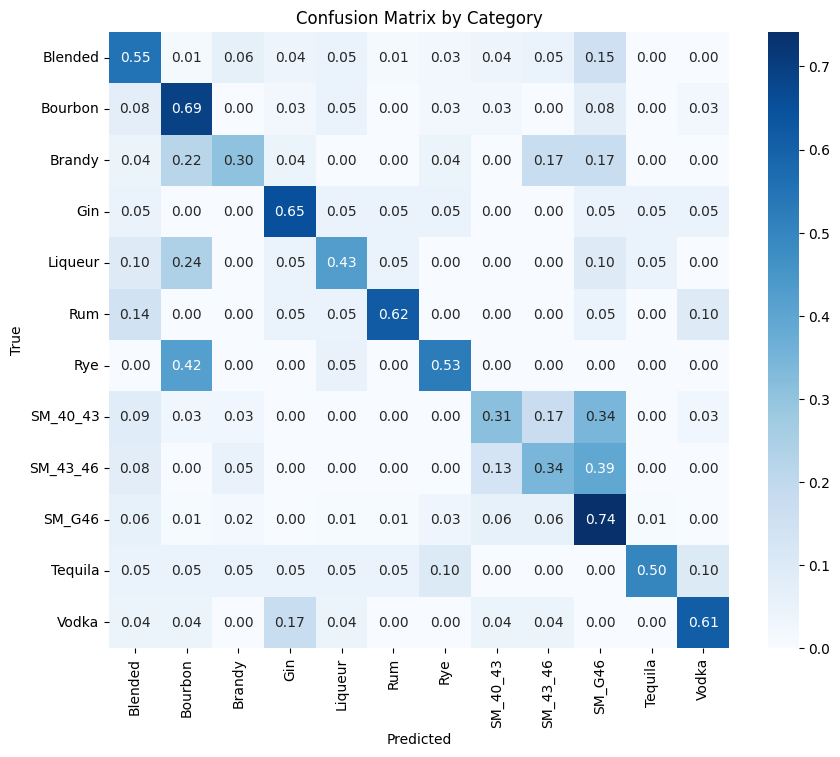

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix by Category")
plt.show()